[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aikhomuokoedion/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aikhomuokoedion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2024-05-11 14:12:17,733 - INFO - Connecting to the database...
2024-05-11 14:12:19,539 - INFO - Fetching data from reddit_usernames...
2024-05-11 14:12:21,205 - INFO - Fetching data from reddit_usernames_comments...
2024-05-11 14:12:28,427 - INFO - Preprocessing data...
2024-05-11 14:12:28,543 - INFO - Labeling data...
2024-05-11 14:12:30,402 - INFO - Correcting labels...
2024-05-11 14:12:30,717 - INFO - Printing the percentage of each label that had to be corrected...
2024-05-11 14:12:30,721 - INFO - Printing random 5 rows of each dataset before and after modification...
2024-05-11 14:12:30,725 - INFO - Printing important statistics or graph about each original dataset...
2024-05-11 14:12:30,75


Percentage of each label that had to be corrected:
label
Veterinarian    0.931915
Other           0.068085
Name: proportion, dtype: float64

reddit_usernames_df before modification:
                  username  isused         subreddit  created_at
5808               bredmlp    True        Veterinary  2024-05-02
6142               jpiggie    True        Veterinary  2024-05-02
1240   Vast-Scientist-8454    True  MysteriumNetwork  2024-05-02
7439        BravoLimaDelta    True        Veterinary  2024-05-02
7181  Extreme-Sandwich-762    True        Veterinary  2024-05-02

reddit_usernames_comments_df before modification:
             username                                           comments  \
464     supawomanblue  How do I exchange the coin from the version I ...   
703       Sqooshytoes  I would not call myself a city person, but I d...   
603    GardeningVet23  They disburse the money on the paycheck that i...   
2641    meow-mountain  ICVA just emailed all NAVLE candidates acknowl...

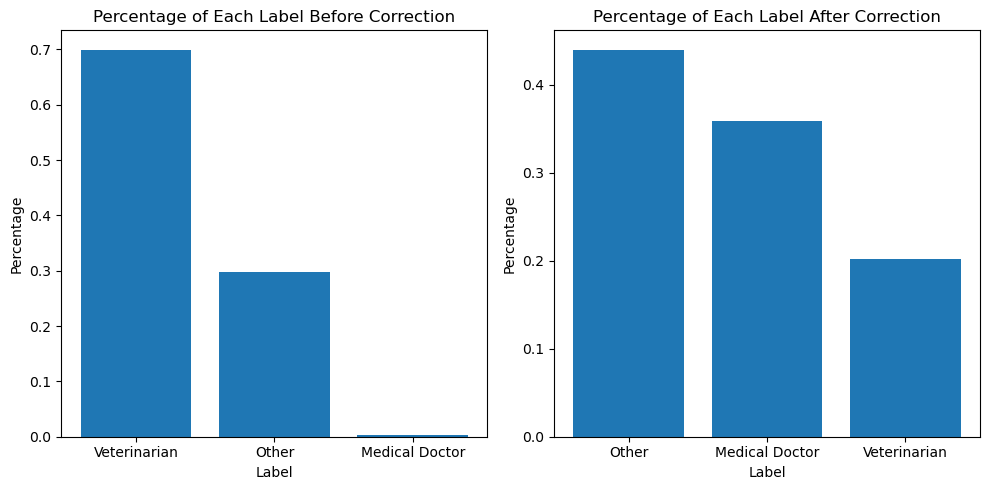

2024-05-11 14:12:30,977 - INFO - Saving the final cleaned and labeled data to a CSV file...
2024-05-11 14:12:31,219 - INFO - Closing database connection...
2024-05-11 14:12:31,221 - INFO - Done.


In [3]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import psycopg2
import logging
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load environment variables from .env file
load_dotenv()

# Get database credentials from environment variables
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USER')
db_pass = os.getenv('DB_PASS')

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Connect to your postgres DB
logging.info('Connecting to the database...')
conn = psycopg2.connect(database=db_name, user=db_user, password=db_pass, host="ep-delicate-river-a5cq94ee-pooler.us-east-2.aws.neon.tech", port="5432")
cur = conn.cursor()

# Fetch data from reddit_usernames
logging.info('Fetching data from reddit_usernames...')
cur.execute("SELECT * FROM reddit_usernames WHERE username IS NOT NULL AND subreddit IS NOT NULL")
reddit_usernames_rows = cur.fetchall()

# Fetch data from reddit_usernames_comments
logging.info('Fetching data from reddit_usernames_comments...')
cur.execute("SELECT * FROM reddit_usernames_comments WHERE username IS NOT NULL")
reddit_usernames_comments_rows = cur.fetchall()

# Initialize stemmer
stemmer = PorterStemmer()

# Define function to preprocess text
def preprocess_text(text):
    if text is None:
        return ''
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) 
    return text

# Preprocess data and store in a DataFrame
logging.info('Preprocessing data...')
reddit_usernames_data = []
for row in reddit_usernames_rows:
    username, isused, subreddit, created_at = row
    reddit_usernames_data.append((username, isused, subreddit, created_at))

reddit_usernames_df = pd.DataFrame(reddit_usernames_data, columns=['username', 'isused', 'subreddit', 'created_at'])

reddit_usernames_comments_data = []
for row in reddit_usernames_comments_rows:
    username, comments = row
    preprocessed_comments = preprocess_text(comments)
    reddit_usernames_comments_data.append((username, preprocessed_comments))

reddit_usernames_comments_df = pd.DataFrame(reddit_usernames_comments_data, columns=['username', 'comments'])

# Label each row in the reddit_usernames_comments_df with the profession of the user
logging.info('Labeling data...')
def label_profession(row):
    username = row['username']
    subreddit = reddit_usernames_df[reddit_usernames_df['username'] == username]['subreddit'].values[0]
    if subreddit.lower().startswith('vet'):
        return 'Veterinarian'
    elif subreddit.lower() == 'medicine':
        return 'Medical Doctor'
    else:
        return 'Other'

reddit_usernames_comments_df['label'] = reddit_usernames_comments_df.apply(label_profession, axis=1)


# Function to read keywords from a file
def read_keywords(file_path):
    with open(file_path, 'r') as file:
        # Remove the single quotes, split by comma, and strip leading/trailing whitespaces
        keywords = [word.strip().replace("'", "") for word in file.read().split(',')]
    return set(keywords)


# Read keywords from files
medical_keywords = read_keywords('medical_keywords.txt')
veterinary_keywords = read_keywords('veterinary_keywords.txt')


# Define function to label profession based on keywords
def label_profession_based_on_keywords(row):
    if row['username'].startswith('test_'):
        return row['label']
    text = row['comments'].lower()
    if any(keyword in text for keyword in medical_keywords):
        return 'Medical Doctor'
    elif any(keyword in text for keyword in veterinary_keywords):
        return 'Veterinarian'
    else:
        return 'Other'

# Correct the labels using the keywords
logging.info('Correcting labels...')
reddit_usernames_comments_df['corrected_label'] = reddit_usernames_comments_df.apply(label_profession_based_on_keywords, axis=1)

# Print the percentage of each label that had to be corrected
logging.info('Printing the percentage of each label that had to be corrected...')
corrections = reddit_usernames_comments_df[reddit_usernames_comments_df['label'] != reddit_usernames_comments_df['corrected_label']]
correction_counts = corrections['label'].value_counts(normalize=True)
print("\nPercentage of each label that had to be corrected:")
print(correction_counts)

# Print random 5 rows of each dataset before and after modification
logging.info('Printing random 5 rows of each dataset before and after modification...')
print("\nreddit_usernames_df before modification:")
print(reddit_usernames_df.sample(5))
print("\nreddit_usernames_comments_df before modification:")
print(reddit_usernames_comments_df.sample(5))

# Print important statistics or graph about each original dataset
logging.info('Printing important statistics or graph about each original dataset...')
print("\nreddit_usernames_df statistics:")
print(reddit_usernames_df.describe(include='all'))
print("\nreddit_usernames_comments_df statistics:")
print(reddit_usernames_comments_df.describe(include='all'))

# Plot the percentage of each label in the whole reddit_usernames_comments_df before and after correction
logging.info('Plotting the percentage of each label in the whole reddit_usernames_comments_df before and after correction...')
label_counts_before = reddit_usernames_comments_df['label'].value_counts(normalize=True)
label_counts_after = reddit_usernames_comments_df['corrected_label'].value_counts(normalize=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(label_counts_before.index, label_counts_before.values)
plt.title('Percentage of Each Label Before Correction')
plt.xlabel('Label')
plt.ylabel('Percentage')

plt.subplot(1, 2, 2)
plt.bar(label_counts_after.index, label_counts_after.values)
plt.title('Percentage of Each Label After Correction')
plt.xlabel('Label')
plt.ylabel('Percentage')

plt.tight_layout()
plt.show()

# Save the final cleaned and labeled data to a CSV file
logging.info('Saving the final cleaned and labeled data to a CSV file...')
reddit_usernames_comments_df.to_csv('reddit_usernames_comments_preprocessed_labeled_corrected.csv', index=False)

# Close connection
logging.info('Closing database connection...')
cur.close()
conn.close()

logging.info('Done.')


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the preprocessed and labeled data from the CSV file
logging.info("Loading data...")
df = pd.read_csv('reddit_usernames_comments_preprocessed_labeled_corrected.csv')

# Print the number of rows with NaN values
nan_rows = df['comments'].isna().sum()
logging.info(f"Number of rows with NaN values: {nan_rows}")

# Remove rows with NaN values
df = df.dropna(subset=['comments'])

# Split the data into training and test sets
logging.info("Splitting data into training and test sets...")

# Count NaN values in 'username' column
nan_count = df['username'].isna().sum()
print(f"Number of NaN values in 'username' column: {nan_count}")

# Fill NaN values in 'username' column
df['username'] = df['username'].fillna('')

# Separate the data
doctor_data = df[df['username'].str.startswith('test_doctor')]
vet_data = df[df['username'].str.startswith('test_vet')]

# Split the 'test_doctor' and 'test_vet' data
train_doctor = doctor_data.iloc[:4]
test_doctor = doctor_data.iloc[-4:]
train_vet = vet_data.iloc[:4]
test_vet = vet_data.iloc[-4:]

# Combine the 'test_doctor' and 'test_vet' data to form the training and test sets
train_df = pd.concat([train_doctor, train_vet])
test_df = pd.concat([test_doctor, test_vet])


# Convert the comments into a matrix of TF-IDF features
logging.info("Vectorizing comments...")
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['comments'])
X_test = vectorizer.transform(test_df['comments'])

# Train a logistic regression model on the training set
logging.info("Training model...")
model = LogisticRegression(max_iter=1000)
model.fit(X_train, train_df['corrected_label'])

# Evaluate the model on the test set
logging.info("Evaluating model...")
y_pred = model.predict(X_test)
print(classification_report(test_df['corrected_label'], y_pred))

print("\nNote: In the above report, a good precision, recall, and F1-score are close to 1.0.")

# Create a method to predict the profession of a user based on a comment
def predict_profession(comment):
    # Preprocess the comment
    comment = preprocess_text(comment)
    # Convert the comment into a matrix of TF-IDF features
    X = vectorizer.transform([comment])
    # Use the model to predict the profession
    prediction = model.predict(X)
    return prediction[0]

# Test the method
logging.info("Testing prediction method...")
comment = "The male patient was diagnosed with malaria."
print(f"The profession of the user who wrote the comment \"{comment}\" is predicted to be: {predict_profession(comment)}")


2024-05-11 14:15:38,154 - INFO - Loading data...
2024-05-11 14:15:38,327 - INFO - Number of rows with NaN values: 1
2024-05-11 14:15:38,329 - INFO - Splitting data into training and test sets...
2024-05-11 14:15:38,334 - INFO - Vectorizing comments...
2024-05-11 14:15:38,338 - INFO - Training model...
2024-05-11 14:15:38,343 - INFO - Evaluating model...
2024-05-11 14:15:38,351 - INFO - Testing prediction method...


Number of NaN values in 'username' column: 1
                precision    recall  f1-score   support

Medical Doctor       0.80      1.00      0.89         4
  Veterinarian       1.00      0.75      0.86         4

      accuracy                           0.88         8
     macro avg       0.90      0.88      0.87         8
  weighted avg       0.90      0.88      0.87         8


Note: In the above report, a good precision, recall, and F1-score are close to 1.0.
The profession of the user who wrote the comment "The male patient was diagnosed with malaria." is predicted to be: Medical Doctor
